Reproduction of the figures presented in 
<cite data-cite="butucea22"> [1] Simultaneous off-the-grid learning of mixtures issued from a continuous dictionary, Butucea, Delmas, Dutfoy, Hardy 2022</cite>

using the algorithm detailed in 
<cite data-cite="butucea21"> [2] Modeling infrared spectra : an algorithm for an automatic and simultaneous
analysis, Butucea, Delmas, Dutfoy, Hardy 2021</cite>


# Useful librairies 

In [1]:
import os, sys 
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir) 
import matplotlib.pyplot as plt
from sliding_frank_wolfe.tools import build_Phi
from sliding_frank_wolfe.dictionary import expo_1D, derivExpo_1D
from sliding_frank_wolfe.SFW_algorithm import SFW
from sliding_frank_wolfe.regularization_parameter import  find_lambda
from sliding_frank_wolfe.group_Lasso_utils import  regressionGroupLasso
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import MultiTaskLasso, MultiTaskLassoCV, Lasso
from sklearn.model_selection import KFold
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

# Generate data

Let us consider the following  parametric function: \begin{equation}
\varphi \colon (\theta,t)\mapsto {\rm e}^{-\frac{(t-\theta)^{2}}{2}}\cdot
\end{equation}
We define the normalized function $\phi$ on $\Theta \subset \mathbb{R}^2$ taking values in $H_T = \mathbb{R}^{T}$ by:
\begin{equation}
\phi(\theta)=\left \|\varphi(\theta)\right \|_2^{-1} \left (\varphi(\theta,t_{1}) , \cdots, \varphi(\theta,t_{T}) \right ).
\end{equation}


We generate random data $Y$ as follows:
\begin{equation}
Y = B^\star \begin{pmatrix} \phi(\theta_{1}^\star)\\
\phi(\theta_{2}^\star)
\end{pmatrix} + W.
\end{equation}
$Y \in \mathbb{R}^{n \times T}$ is the matrix of observations ($n$ signals discretized on $T$ points), $B^\star \in \mathbb{R}^{n \times 2}$ is a matrix of linear coefficients, $\phi(\theta_{1}^\star)$ and $\phi(\theta_{2}^\star)$ are the two the discretized peaks such that $|\theta_1^\star - \theta_2^\star| =\delta$, $W \in \mathbb{R}^{n \times T}$ is the noise (the entries are independent centered Gaussian random variables).


In [2]:
T = 100         #number of points in the grid
n = 100            #number of signals
noise_level = 0.1        #standard deviation of the gaussian noise
delta = 3             #distance between the two considered spikes
times = np.linspace(-10,10,T)     #grid over which the signals are discretized
location_parameters =  np.array([0,delta])       #table containing the location of the spikes

parameters = np.zeros((2,1))
parameters[:,0] = location_parameters

B = np.random.uniform(-10,10,size=(n,2))       #amplitudes of the spikes fixed at random
PHI_transpose = build_Phi(times, parameters, 2, 0, True,expo_1D)   #build a matrix containing all the parametric functions
BPHI = np.dot(B,np.transpose(PHI_transpose))  #compute the matrix product between the features and the amplitudes
W = np.random.normal(0,noise_level,size = BPHI.shape) # noise
Y = BPHI + W             #signals

# Plot data

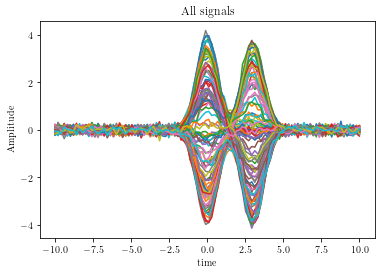

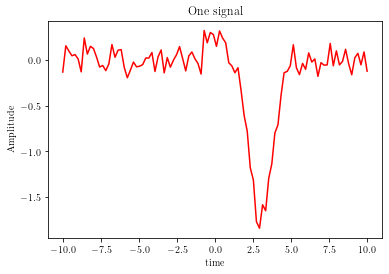

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig = plt.figure()
plt.title('All signals')
plt.plot(times,np.transpose(Y))
plt.ylabel('Amplitude')
plt.xlabel('time')
plt.show()


fig = plt.figure()
plt.title('One signal')
plt.plot(times,Y[4,:],color = 'red')
plt.ylabel('Amplitude')
plt.xlabel('time')
plt.show()

# Parameters of the SFW algorithm

In [4]:
help(SFW)

Help on function SFW in module sliding_frank_wolfe.SFW_algorithm:

SFW(data, times, reg, lower_bounds, upper_bounds, func, deriv_func, threshold=0.0001, merging_threshold=0.0001, rank='full', size_grids=None, normalized=True, epsilon=0.0001, max_iter=100, size_mesh=1000, positive=False)
    Run the sliding Frank-Wolfe algorithm on a set of n signals disctretized on p points. The signals are approximated by
    linear combinations of parametric functions "func". The parametric functions are parametrized by a parameter of dimension d.
    
    Parameters
    ----------
    data : array, shape (p,n)
        array of n signals distretized on p points.
    
    times : array, shape(p,)
        array of size p corresponding to the points over which the signals are discretized.
    
    reg : float
        regularization parameter of the optimization problem.
    
    lower_bounds : array, shape(d,)
        lower_bounds on the parameters of the parametric functions. The k-th coordinate of the

### Parameters

In [5]:
low_location_parameters = np.minimum(times[0],times[-1])
up_location_parameters = np.maximum(times[0],times[-1])
low_scaling_parameters = 1
up_scaling_parameters = 1
upper_bounds = [up_location_parameters] #lower bounds on the parameter
lower_bounds = [low_location_parameters] #upper bounds on the parameter
size_grids  = [100]
phi = expo_1D   #parametric function
deriv_phi = derivExpo_1D #derivative of the parametric function
merging_threshold = 0 
threshold = 1e-8
epsilon = 0
K = 50 

# group Lasso VS group BLasso

In order to reconstruct the signals, we perform the group Lasso on refined grids and the group BLasso for different values of the penalization parameter and we compare the mean square error and the sparsity of the solutions. The reconstructions obtained with the group Lasso depends on the discretization scheme used on the parameter space.

In [6]:
nb_refinements = 3
nb_penalization = 50
MSE_grid_GL  = np.zeros((nb_refinements,nb_penalization))
MSE_GBL  = np.zeros(nb_penalization)
sparsity_grid_GL = np.zeros((nb_refinements,nb_penalization))
sparsity_GBL = np.zeros(nb_penalization)
length_grids_GL = np.zeros(nb_refinements)
N_start = 3
lbda = np.linspace(5e-5, 1e-3, nb_penalization)

for j in range(nb_penalization):
    #group BLasso
    res_optim = SFW(np.transpose(Y), times, lbda[j], lower_bounds, upper_bounds, phi, deriv_phi,merging_threshold = merging_threshold, threshold = threshold, max_iter = K, epsilon = epsilon, positive = False)
    sparsity_GBL[j] =  res_optim.sparsity 
    B_optim = res_optim.linear_coefficients
    parameters_optim = res_optim.dictionary_parameters
    PHI_optim_T = build_Phi(times, parameters_optim, res_optim.sparsity,0, normalized = True,func=phi)
    BPHI_optim = np.dot(B_optim,np.transpose(PHI_optim_T))
    MSE_GBL[j] =  (1. / (T * n)) * np.linalg.norm(BPHI - BPHI_optim, ord = 'fro')**2
    #group Lasso
    for i in range(N_start,nb_refinements+N_start):
        step_grid = delta / (2**i)
        positive_grid =  np.arange(step_grid/2, 10,step_grid)
        negative_grid = np.sort(-1*positive_grid)
        grid_parameter = np.hstack((negative_grid ,positive_grid))
        length_grids_GL[i-N_start]  = len(grid_parameter) 
        table = np.zeros((len(grid_parameter),1))
        table[:,0] = grid_parameter
        design_matrix = build_Phi(times, table, len(grid_parameter), 0, True,expo_1D) 
        coef_GL = MultiTaskLasso(alpha = lbda[j] * T /2  , fit_intercept = False).fit(design_matrix, Y.T).coef_
        BPHI_GL = np.dot(coef_GL,design_matrix.T)
        MSE_grid_GL[i-N_start,j] = (1. /( T * n)) * np.linalg.norm(BPHI - BPHI_GL, ord='fro')**2
        norms_features = np.linalg.norm(coef_GL,ord = 2, axis = 0)
        sparsity_grid_GL[i-N_start,j] = np.size(norms_features[norms_features > 0])



/home/clement/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:1951: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7430906655555845, tolerance: 0.7300441997755768
  cd_fast.enet_coordinate_descent_multi_task(
/home/clement/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:1951: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7475166161570996, tolerance: 0.7300441997755768
  cd_fast.enet_coordinate_descent_multi_task(
/home/clement/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:1951: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7817214270154977, tolerance: 0.7300441997755768
  cd_fast.enet_coordinate_descent_multi_task(
/home/clement/anaconda3/lib/python3.8/site-packages/sklearn/line

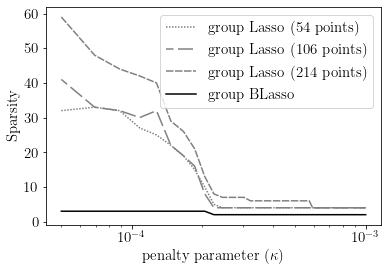

In [7]:
linestyles = [(0, (1, 1)),(5, (10, 3)),(0, (5, 1))]


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots()
for i in range(len(length_grids_GL)):
    ax.plot(lbda, sparsity_grid_GL[i,:], color = 'grey', linestyle = linestyles[i%3], label = 'group Lasso ({} points)'.format(int(length_grids_GL[i])))
ax.plot(lbda, sparsity_GBL, color = 'black', linestyle = 'solid', label = 'group BLasso')
#ax.set_title('Sparsity of the solutions given by the group Lasso and the group BLasso')
plt.ylabel('Sparsity')
plt.xlabel('penalty parameter ($\kappa$)')
plt.xscale('log')
plt.legend()
plt.show()        
        

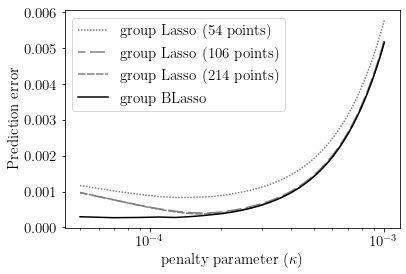

In [8]:
linestyles = [(0, (1, 1)),(5, (10, 3)),(0, (5, 1))]



plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots()
for i in range(len(length_grids_GL)):
    ax.plot(lbda, MSE_grid_GL[i,:], color = 'grey', linestyle = linestyles[i%3], label = 'group Lasso ({} points)'.format(int(length_grids_GL[i])))
ax.plot(lbda, MSE_GBL, color = 'black', linestyle = 'solid', label = 'group BLasso')

#ax.set_title('Prediction errors obtained by the group Lasso and the group BLasso')
plt.ylabel('Prediction error')
plt.xlabel('penalty parameter ($\kappa$)')
plt.legend()
plt.xscale('log')
plt.show()

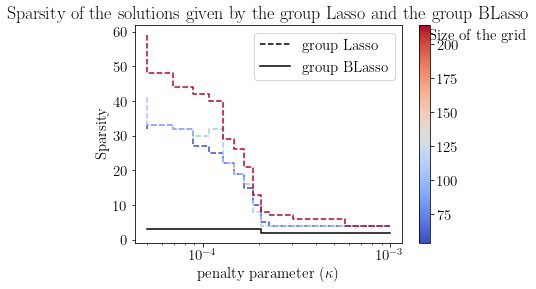

In [9]:

param_values = length_grids_GL
norm = Normalize(vmin= np.min(length_grids_GL), vmax=np.max(length_grids_GL))
param_values_normalized = norm(param_values)

fig, ax = plt.subplots()

for i, val in enumerate(param_values):
    color = plt.cm.get_cmap('coolwarm')(param_values_normalized[i]) 
    ax.step(lbda, sparsity_grid_GL[i,:], color=color, label=f'Courbe {i+1}',linestyle = 'dashed')

ax.step(lbda, sparsity_GBL, color = 'black')
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])  
cbar = plt.colorbar(sm, ax=ax)
# Annotation dans un rectangle à droite de la barre de couleur
rect = plt.Rectangle((1.02, 0), 0.35, 1, transform=ax.transAxes, clip_on=False, edgecolor='white', facecolor='white')
ax.add_artist(rect)
ax.annotate('Size of the grid', xy=(1.10, 0.95), xycoords='axes fraction', ha='left', va='center')

custom_lines = [Line2D([0], [0], color='black', linestyle='dashed'),
                Line2D([0], [0], color='black', linestyle='solid')]
ax.legend(custom_lines,  ['group Lasso', 'group BLasso'])


ax.set_title('Sparsity of the solutions given by the group Lasso and the group BLasso')
plt.ylabel('Sparsity')
plt.xlabel('penalty parameter ($\kappa$)')
plt.xscale('log')
plt.show()        
        
        



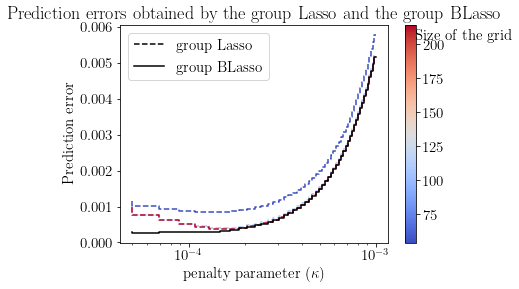

In [10]:

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

param_values = length_grids_GL
norm = Normalize(vmin= np.min(length_grids_GL), vmax=np.max(length_grids_GL))
param_values_normalized = norm(param_values)

fig, ax = plt.subplots()

for i, val in enumerate(param_values):
    color = plt.cm.get_cmap('coolwarm')(param_values_normalized[i]) 
    ax.step(lbda, MSE_grid_GL[i,:], color=color, label=f'Courbe {i+1}',linestyle = 'dashed')

ax.step(lbda, MSE_GBL, color = 'black')
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])  
cbar = plt.colorbar(sm, ax=ax)
# Annotation dans un rectangle à droite de la barre de couleur
rect = plt.Rectangle((1.02, 0), 0.35, 1, transform=ax.transAxes, clip_on=False, edgecolor='white', facecolor='white')
ax.add_artist(rect)
ax.annotate('Size of the grid', xy=(1.10, 0.95), xycoords='axes fraction', ha='left', va='center')

custom_lines = [Line2D([0], [0], color='black', linestyle='dashed'),
                Line2D([0], [0], color='black', linestyle='solid')]
ax.legend(custom_lines,  ['group Lasso', 'group BLasso'])


ax.set_title('Prediction errors obtained by the group Lasso and the group BLasso')
plt.ylabel('Prediction error')
plt.xlabel('penalty parameter ($\kappa$)')
plt.xscale('log')
plt.show()      